# Exploratory Data Analysis

## Imports

In [36]:
import pandas as pd
import numpy as np
import nltk
import re
import time
import pandas_profiling
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

%matplotlib inline

## Reading in Data

In [12]:
df = pd.read_csv('../data/Reviews.csv')

In [13]:
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

## General Statistics

Getting the number of `NA`s in each column:

In [14]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

Find the number of unique values in each column

In [15]:
df.nunique()

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218416
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64

In [27]:
unique_products = df.groupby('ProductId')['ProductId'].count()
print('Number of products in the dataset:', len(unique_products))

Number of products in the dataset: 74258


In [28]:
unique_users = df.groupby('UserId')['UserId'].count()
print('Number of users in dataset:', len(unique_users))

Number of users in dataset: 256059


## Distribution of Helpfulness Denominator

HelpfulnessDenominator is the number of people who answered if the review was helpful or not. Let us take a look at the median number of people who answered this question.

<AxesSubplot:>

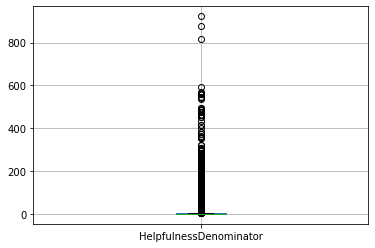

In [16]:
df.boxplot(column='HelpfulnessDenominator')

In [17]:
np.median(df['HelpfulnessDenominator'])

1.0

Let us compute Helpfulness=HelpfulnessNumerator/HelpfulnessDenominator

In [18]:
df['Helpfulness'] = df['HelpfulnessNumerator']/df['HelpfulnessDenominator']
df['Helpfulness'].fillna(0, inplace=True)

array([[<AxesSubplot:title={'center':'Helpfulness'}>]], dtype=object)

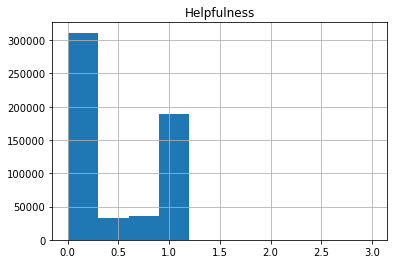

In [19]:
df.hist(column='Helpfulness')

In [20]:
df['HelpDiff'] = df['HelpfulnessDenominator'] - df['HelpfulnessNumerator']

In [21]:
df[df['HelpDiff'] < 0]

Id   ProductId          UserId              ProfileName  \
44736  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   
64421  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   

       HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
44736                     3                       2      4  1212883200   
64421                     3                       1      5  1224892800   

                                            Summary  \
44736  Pure cocoa taste with crunchy almonds inside   
64421             Bought This for My Son at College   

                                                    Text  Helpfulness  \
44736  It was almost a 'love at first bite' - the per...          1.5   
64421  My son loves spaghetti so I didn't hesitate or...          3.0   

       HelpDiff  
44736        -1  
64421        -2

We have 2 rows where the HelpfulnessNumerator is greater than HelpfulnessDenominator

In [40]:
df.loc[:, 'Helpful'] = np.where(df.loc[:, 'Helpfulness'] > 0.50, 1, 0)

## Sentiment Classes

Here, we'll assume that reviews with 3 stars or less is a `negative = 0` sentiment, and reviews greater than 3 stars is a `positive = 1` sentiment.

In [22]:
df.loc[df['Score'] <= 3, 'ReviewSentiment'] = 0
df.loc[df['Score'] > 3, 'ReviewSentiment'] = 1

In [23]:
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   
3         Cough Medicine  If you are looking for the secret ingredient i...   
4            Great taffy  Great taffy at a great price.  There was a wid...   

   Helpfulness  HelpDiff  ReviewSentiment  
0          1.0         0              1.0  
1          0.0         0              0.0  
2          1.0         0              1.0  
3          1.0         0              0.0  
4          0.0         0              1.0

array([[<AxesSubplot:title={'center':'Score'}>]], dtype=object)

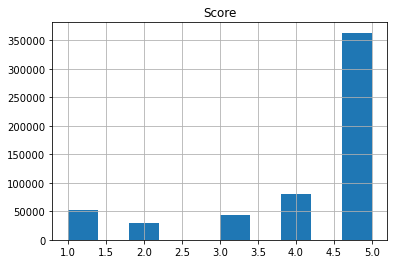

In [24]:
df.hist(column = 'Score')

array([[<AxesSubplot:title={'center':'ReviewSentiment'}>]], dtype=object)

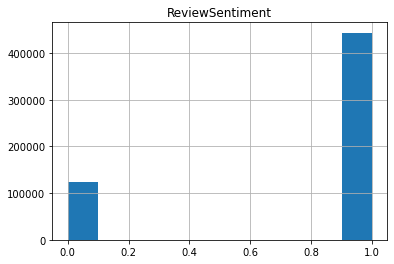

In [26]:
df.hist(column='ReviewSentiment')

Here, we see that we have a classic class imbalance problem, with positive reviews being vastly overrepresented in our dataset.

## Positive vs. Negative Review Characteristics

In [34]:
# Get word cloud for positive and negative reviews
pos_reviews = df.loc[df['ReviewSentiment'] == 1.0]
neg_reviews = df.loc[df['ReviewSentiment'] == 0.0]

def preprocess(text):
    text = re.sub('[^a-z]', '', text)
    return text

def get_corpus(data):
    count = 0
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer() 
    corpus = ''
    for text in tqdm(data['Summary']):        
        text = str(text).lower()
        text = preprocess(text)
        tokens = nltk.word_tokenize(text)
        for token in tokens:
            if token in stop_words:
                continue
            token = lemmatizer.lemmatize(token)
            corpus = corpus + ' ' + token
        #count += 1
        #if count%1000 == 0:
        #    print(count, end = ' ')
    return corpus

In [35]:
start_time = time.time()
neg_corpus = get_corpus(neg_reviews)
end_time = time.time()
print('Time taken:', (end_time - start_time))

100%|█████████████████████████████████████████████████████████████████████████| 124677/124677 [04:20<00:00, 478.66it/s]

Time taken: 260.4810428619385


In [44]:
pos_corpus = get_corpus(pos_reviews)

100%|█████████████████████████████████████████████████████████████████████████| 443777/443777 [46:08<00:00, 160.29it/s]


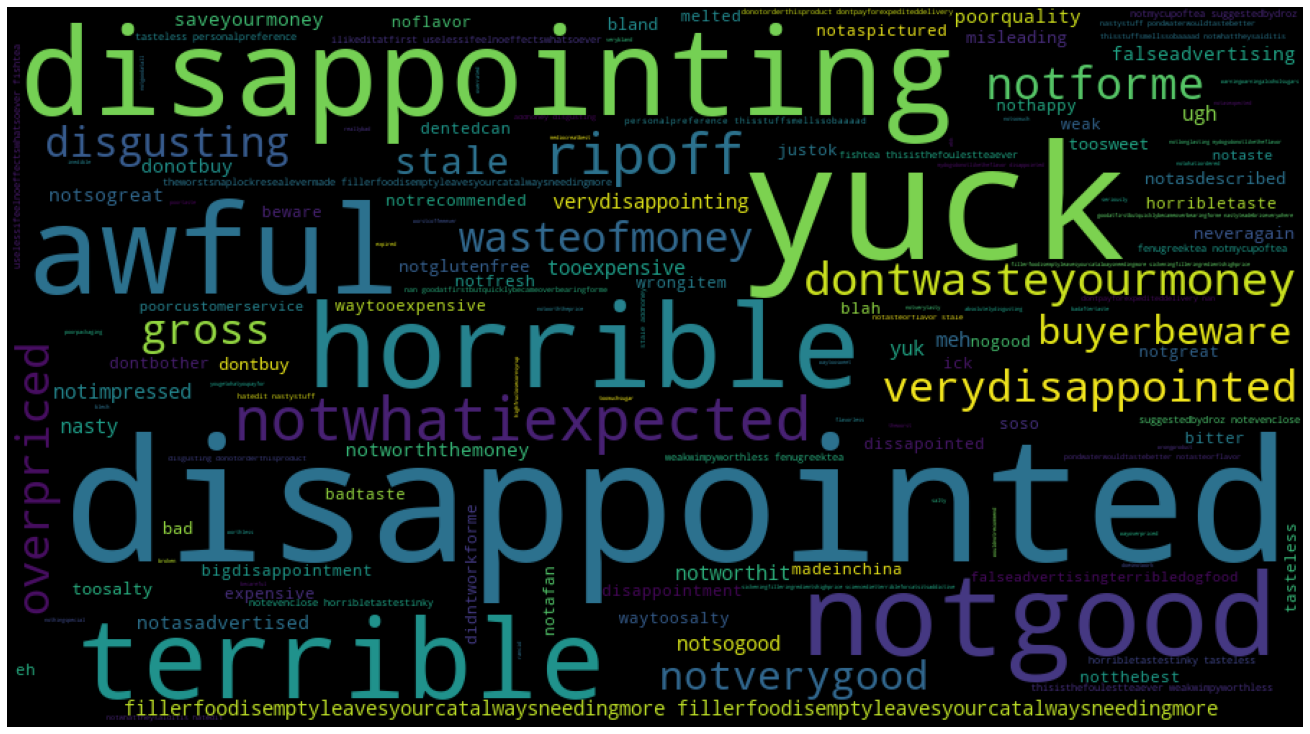

In [30]:
def plot_wordcloud(wordcloud):
    plt.figure( figsize=(20,10), facecolor='w')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

neg_wordcloud = WordCloud(width=900, height=500).generate(neg_corpus)
plot_wordcloud(neg_wordcloud)

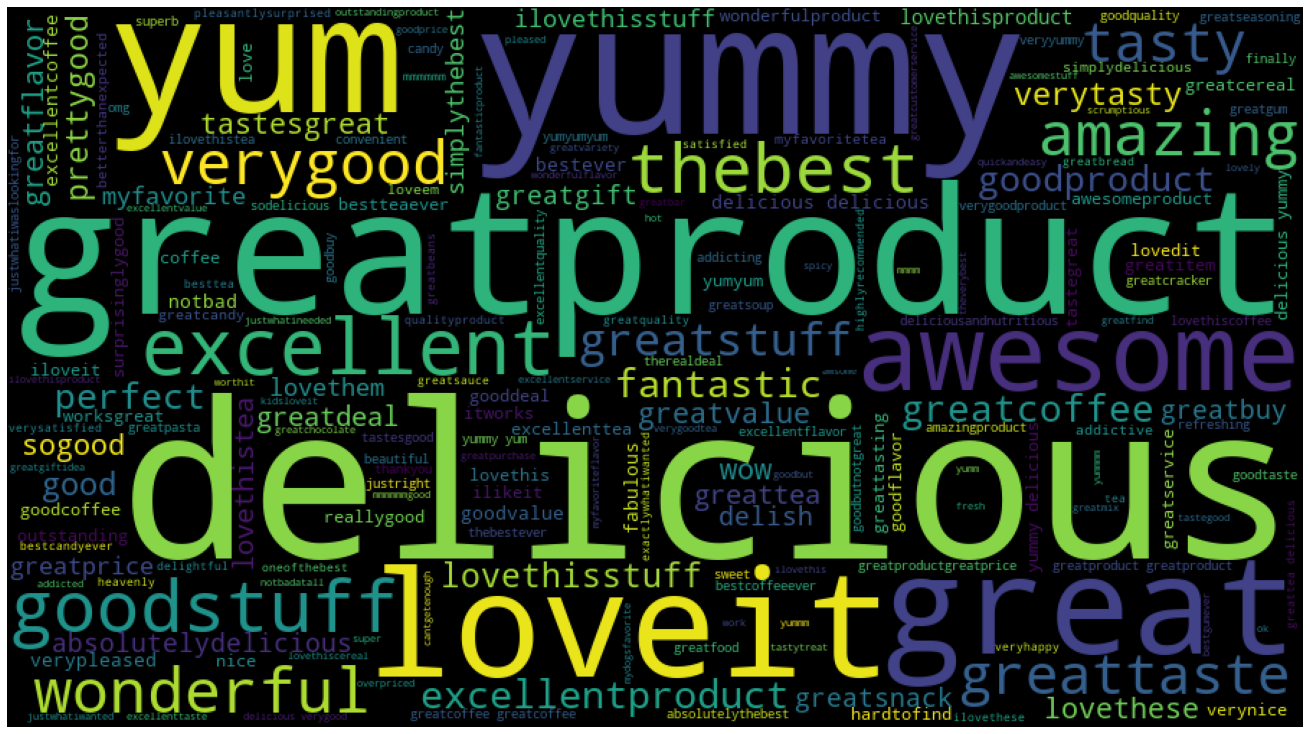

In [31]:
pos_wordcloud = WordCloud(width=900, height=500).generate(pos_corpus)
plot_wordcloud(pos_wordcloud)

In [32]:
def remove_spl_chars(text):
    text = str(text).lower()
    text = re.sub('[^a-z ]', '', text)
    return text 


def get_num_words(data):
    count = 0
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer() 
    num_words = []
    for text in data['Text']:
        
        text = remove_spl_chars(text)
        words = text.split(' ')

        final_words = set()
        for word in words:
            if word in stop_words:
                continue

            word = lemmatizer.lemmatize(word)
            final_words.add(word)    
        
        num_words.append(len(final_words))
        count += 1
        
    return num_words

In [33]:
num_pos_words = get_num_words(pos_reviews)

In [34]:
num_neg_words = get_num_words(neg_reviews)

In [35]:
def show_len_hist(num_words, color, title):
    plt.hist(num_words, bins=100, color=color)
    plt.xlabel('Length of Negative Review')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(True)
    plt.xlim(0,200)
    plt.show()

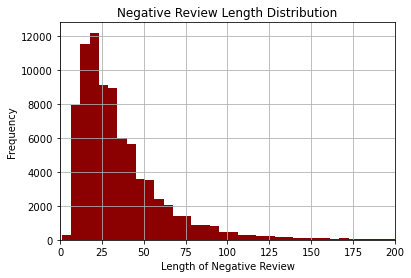

In [36]:
show_len_hist(num_neg_words, 'darkred', 'Negative Review Length Distribution')

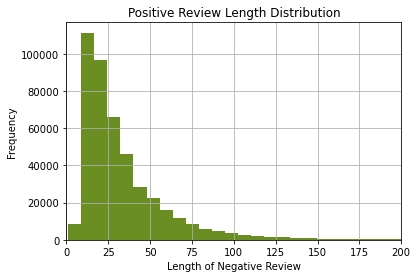

In [37]:
show_len_hist(num_pos_words, 'olivedrab', 'Positive Review Length Distribution')

In [42]:
df.head(3)

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   

   Helpfulness  HelpDiff  ReviewSentiment  Helpful  
0          1.0         0              1.0        1  
1          0.0         0              0.0        0  
2          1.0         0              1.0        1

In [43]:
df.replace('', np.nan, inplace=True)
# Run Pandas profiling
profile = pandas_profiling.ProfileReport(df) 
profile.to_notebook_iframe()